In [193]:
suppressMessages(require(Seurat))
suppressMessages(require(ggplot2))
suppressMessages(require(dplyr))
suppressMessages(require(reticulate))
suppressMessages(require(stringr))
suppressMessages(require(ggpubr))
suppressMessages(require(viridisLite))

In [194]:
source('modules/assesNumberOfCellsPerSpot.R')
source('modules/globalParams.R')

In [195]:
out.figs.dir <- '../2.results/review01/figs'
out.data.dir <- '../2.results/review01/data'

In [196]:
dir.create(out.figs.dir, showWarnings = FALSE, recursive = TRUE)
dir.create(out.data.dir, showWarnings = FALSE, recursive = TRUE)

In [255]:
estCellPerSpots <- function(sp.obj, max.cells = 12, fix.cells.in.spot = NULL, quantile.cut = 0.90, num.genes = 2000) {
    if (!is.null(fix.cells.in.spot)) {
        pred.cnt <- rep(fix.cells.in.spot, ncol(sp.obj)) %>% `names<-`(colnames(sp.obj))
    } else {
        sp.obj <- NormalizeData(sp.obj) %>% FindVariableFeatures(., nfeatures = 10000)
        genes <- VariableFeatures(sp.obj)
        count.mat <- GetAssayData(sp.obj, slot = "count", assay = "Spatial") %>% as.data.frame()
        count.mat <- count.mat[genes, ]
        options(warn = -1)
        cor1 <- apply(count.mat, 1, function(xx) cor(sp.obj$nCount_Spatial, xx, method = 'spearman'))
        cor2 <- apply(count.mat, 1, function(xx) cor(sp.obj$nFeature_Spatial, xx, method = 'spearman')) 
        cor.bak <- cor1 * cor2
        cor.bak <- cor.bak[!is.na(cor.bak)]
        cor.bak <- cor.bak[order(-cor.bak)]
        #genes <- VariableFeatures(sp.obj)
        genes <- names(cor.bak)[1:num.genes]
        cnt.sum <- colSums(count.mat[genes, ])
        ref.cut <- quantile(cnt.sum, quantile.cut)
        ref.df <- rowMeans(count.mat[, which(cnt.sum >= ref.cut), drop = FALSE])
        ref.df <- ref.df[genes]
        count.mat <- count.mat[genes, ]
        pred.cnt <- apply(count.mat, 2, function(gg) ceiling(coef(MASS::rlm(gg ~ ref.df - 1, maxit = 100)) * max.cells))
        pred.cnt[pred.cnt <= 0] <- 1
        pred.cnt[pred.cnt > max.cells] <- max.cells
    }
    return(pred.cnt)
}

In [198]:
RMSE = function(m, o){
  sqrt(mean((m - o)^2))
}

In [199]:
calcSpotsDist <- function(sp.obj, knn = 5) {
    image.coord <- GetTissueCoordinates(sp.obj)
    dist.lst <- lapply(levels(sp.obj), function(idx) {
        sub.spots <- Idents(sp.obj)[Idents(sp.obj) == idx] %>% names()
        dbscan::kNN(na.omit(image.coord[sub.spots, c(1, 2)]), k = knn)$id
    }) %>% `names<-`(levels(sp.obj))
    return(dist.lst)
}

### Dataset 1

In [200]:
require(ggpointdensity)

In [524]:
dapi.cnt <- read.table('DAPI//mouse.1/mouse_predix.xls', sep = '\t', row.names = 1, header = TRUE)[, 1, drop = FALSE]
head(dapi.cnt)

,segmentation_label
,<int>
AAACAAGTATCTCCCA-1,3
AAACAGAGCGACTCCT-1,0
AAACAGTGTTCCTGGG-1,1
AAACATTTCCCGGATT-1,8
AAACCGGGTAGGTACC-1,6
AAACCGTTCGTCCAGG-1,4


In [525]:
sp.obj <- Load10X_Spatial('DAPI/mouse.1/', filename = 'V1_Adult_Mouse_Brain_Coronal_Section_2_filtered_feature_bc_matrix.h5')

In [515]:
our.cnt <- estCellPerSpots(sp.obj, quantile.cut = 0.95, num.genes = 100)
#our.cnt <- estCellPerSpots(sp.obj, quantile.cut = 0.90, num.genes = 5000)

In [516]:
our.cnt = our.cnt[rownames(dapi.cnt)]
cor(our.cnt, dapi.cnt[, 1] + 1, method = 'spearman')

[1] 0.6224446

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


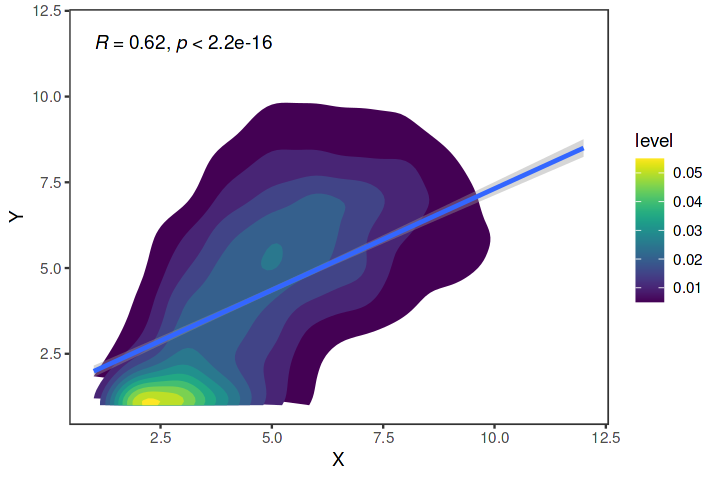

In [517]:
options(repr.plot.width = 6, repr.plot.height = 4)
plot.data <- cbind.data.frame(X = our.cnt, Y = dapi.cnt[, 1] + 1) #%>% { log2(.) }
#ggplot(plot.data, aes(x = X, y = Y)) + geom_pointdensity() + geom_smooth(method = 'lm') + theme_bw() + theme(panel.grid = element_blank()) + stat_cor(method = "pearson") + viridis::scale_color_viridis() + xlab('Predicted by Cell2Spatial') + ylab('Counted using VistoSeg tool')
ggplot(plot.data, aes(x = X, y = Y)) + stat_density2d(geom = 'polygon', aes(fill = stat(level))) + geom_smooth(method = 'lm') + theme_bw() + theme(panel.grid = element_blank()) + stat_cor(method = "spearman") + viridis::scale_fill_viridis()
ggsave(file.path(out.figs.dir, 'data.1.cell2spatial.dapi.pdf'), width = 6, height = 4)

In [518]:
cytospace <- import('cytospaceMethod')
cytospace.est <- cytospace$estimate_cell_number_RNA_reads(as.data.frame(GetAssayData(sp.obj, slot = 'count')), mean(dapi.cnt[, 1]))
names(cytospace.est) <- colnames(sp.obj)

In [519]:
sp.obj <- sp.obj[, names(our.cnt)]
sp.obj$Ours <- our.cnt
sp.obj$DAPI <- dapi.cnt[, 1] + 1
sp.obj$cytospace <- cytospace.est[names(our.cnt)]

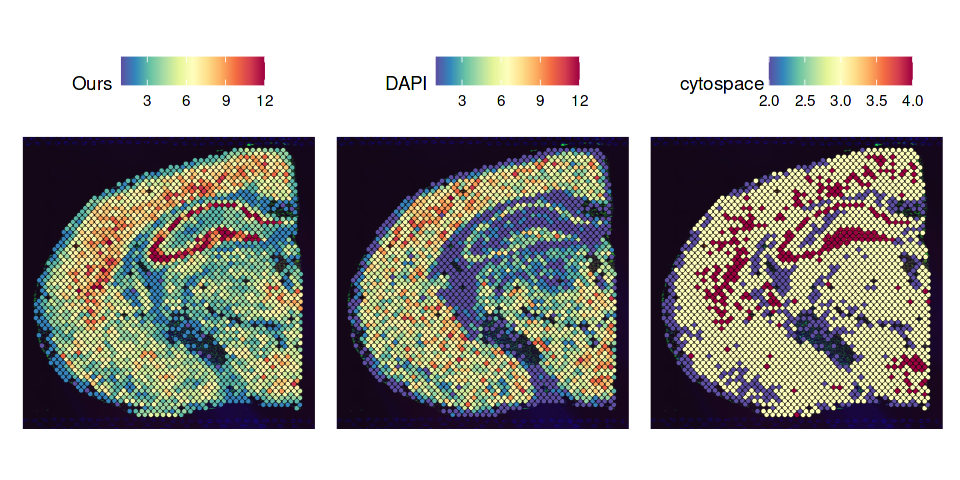

In [520]:
options(repr.plot.width = 8, repr.plot.height = 4)
SpatialFeaturePlot(sp.obj, features = c('Ours', 'DAPI', 'cytospace'))
ggsave(file.path(out.figs.dir, 'data1.spatial.dapi.vs.cell2spatial.pdf'), width = 8, height = 4)

In [390]:
plot.df <- cbind.data.frame(Ours = RMSE(sp.obj$Ours, sp.obj$DAPI), CytoSPACE = RMSE(sp.obj$cytospace, sp.obj$DAPI))
head(plot.df)

,Ours,CytoSPACE
,<dbl>,<dbl>
1,2.515915,2.748403


In [391]:
cor(sp.obj$cytospace, sp.obj$DAPI, method = 'spearman')

[1] 0.5168174

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


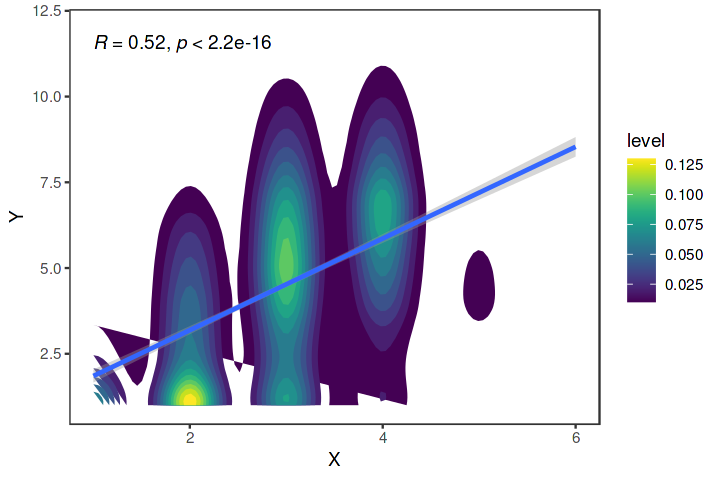

In [392]:
options(repr.plot.width = 6, repr.plot.height = 4)
plot.data <- cbind.data.frame(X = sp.obj$cytospace, Y = dapi.cnt[, 1] + 1) #%>% { log2(.) }
#ggplot(plot.data, aes(x = X, y = Y)) + geom_pointdensity() + geom_smooth(method = 'lm') + theme_bw() + theme(panel.grid = element_blank()) + stat_cor(method = "pearson") + viridis::scale_color_viridis() + xlab('Predicted by Cell2Spatial') + ylab('Counted using VistoSeg tool')
ggplot(plot.data, aes(x = X, y = Y)) + stat_density2d(geom = 'polygon', aes(fill = stat(level))) + geom_smooth(method = 'lm') + theme_bw() + theme(panel.grid = element_blank()) + stat_cor(method = "spearman") + viridis::scale_fill_viridis()
ggsave(file.path(out.figs.dir, 'data.1.cytospace.dapi.pdf'), width = 6, height = 4)

In [526]:
res.1 <- parallel::mclapply(seq(100, 10000, 200), function(idx) {
    our.cnt <- estCellPerSpots(sp.obj, quantile.cut = 0.95, num.genes = idx)
    our.cnt = our.cnt[rownames(dapi.cnt)]
    return(c(Cor = cor(our.cnt, dapi.cnt[, 1] + 1, method = 'spearman'), Idx = idx))
}, mc.cores = 1) %>% do.call(rbind, .)

In [528]:
head(res.1)

Cor,Idx
0.6224446,100
0.6098385,300
0.6071544,500
0.6068313,700
0.6051312,900
0.6035315,1100


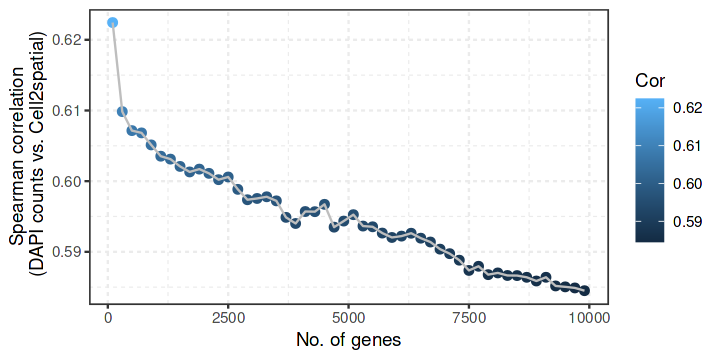

In [530]:
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(res.1, aes(x = Idx, y = Cor)) + geom_point(aes(color = Cor), size = 2) + geom_line(color = 'grey') + theme_bw() + theme(panel.grid = element_line(linetype = 'dashed')) + xlab('No. of genes') + ylab('Spearman correlation\n (DAPI counts vs. Cell2spatial)')

ggsave(file.path(out.figs.dir, 'data1.dapi.vs.genes.count.pdf'), width = 6, height = 3)
openxlsx::write.xlsx(data.frame(res.1), file = file.path(out.data.dir, 'data1.dapi.vs.genes.count.xlsx'))

### Load data for mouse brain

In [543]:
dapi.cnt <- read.table('../0.data/DAPI/mouse.brain.3/DAPI.xls', sep = '\t', row.names = 1, header = TRUE)[, 1, drop = FALSE]
head(dapi.cnt)
dim(dapi.cnt)

,segmentation_label
,<int>
AAACAAGTATCTCCCA-1,1
AAACACCAATAACTGC-1,7
AAACAGAGCGACTCCT-1,2
AAACAGTGTTCCTGGG-1,4
AAACCCGAACGAAATC-1,1
AAACCGGGTAGGTACC-1,7


[1] 2438    1

In [544]:
table(dapi.cnt$segmentation_label)


  0   1   2   3   4   5   6   7   8   9  10  11  12  13 
219 903 110 165 210 220 230 179 117  49  25   7   3   1 

In [545]:
sp.obj <- Load10X_Spatial('../0.data/DAPI/mouse.brain.3/', filename = 'Visium_FFPE_Mouse_Brain_IF_filtered_feature_bc_matrix.h5')

In [546]:
our.cnt <- estCellPerSpots(sp.obj, quantile.cut = 0.95, num.genes = 2000, max.cells = 14)

In [547]:
our.cnt = our.cnt[rownames(dapi.cnt)]
cor(our.cnt, dapi.cnt[, 1], method = 'spearman')

[1] 0.6505021

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


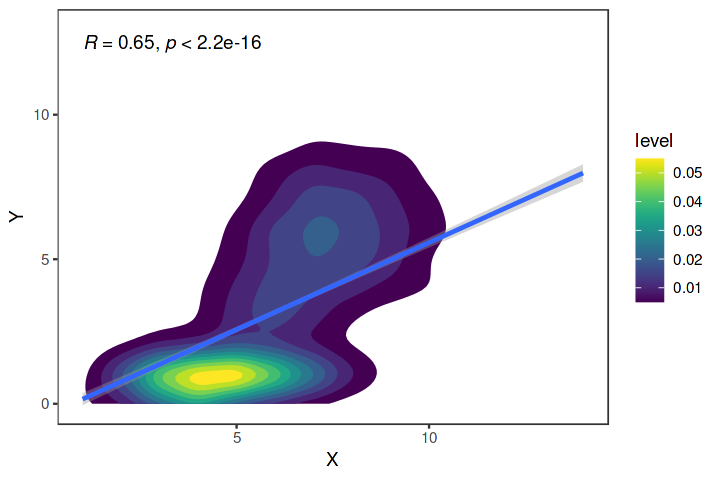

In [506]:
options(repr.plot.width = 6, repr.plot.height = 4)
plot.data <- cbind.data.frame(X = our.cnt, Y = dapi.cnt[, 1]) #%>% { log2(.) }
#ggplot(plot.data, aes(x = X, y = Y)) + geom_pointdensity() + geom_smooth(method = 'lm') + theme_bw() + theme(panel.grid = element_blank()) + stat_cor(method = "pearson") + viridis::scale_color_viridis() + xlab('Predicted by Cell2Spatial') + ylab('Counted using VistoSeg tool')
ggplot(plot.data, aes(x = X, y = Y)) + stat_density2d(geom = 'polygon', aes(fill = stat(level))) + geom_smooth(method = 'lm') + theme_bw() + theme(panel.grid = element_blank()) + stat_cor(method = "spearman") + viridis::scale_fill_viridis()
ggsave(file.path(out.figs.dir, 'data.2.cell2spatial.dapi.pdf'), width = 6, height = 4)

In [553]:
cytospace <- import('cytospaceMethod')
cytospace.est <- cytospace$estimate_cell_number_RNA_reads(as.data.frame(GetAssayData(sp.obj, slot = 'count')), median(dapi.cnt[, 1]) + 1)
names(cytospace.est) <- colnames(sp.obj)

In [554]:
sp.obj <- sp.obj[, names(our.cnt)]
sp.obj$Ours <- our.cnt
sp.obj$DAPI <- dapi.cnt[, 1] + 1
sp.obj$cytospace <- cytospace.est[names(our.cnt)]

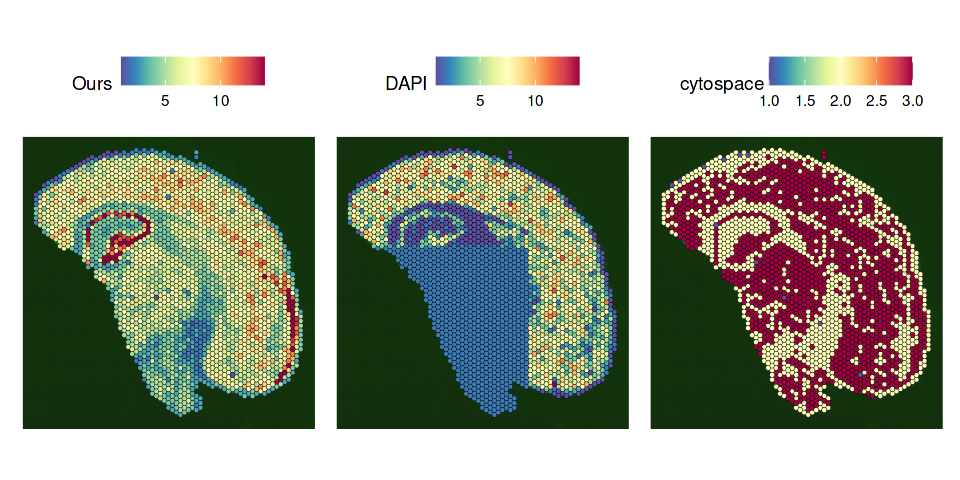

In [555]:
options(repr.plot.width = 8, repr.plot.height = 4)
SpatialFeaturePlot(sp.obj, features = c('Ours', 'DAPI', 'cytospace'))
ggsave(file.path(out.figs.dir, 'spatial.dapi.vs.cell2spatial.pdf'), width = 8, height = 4)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


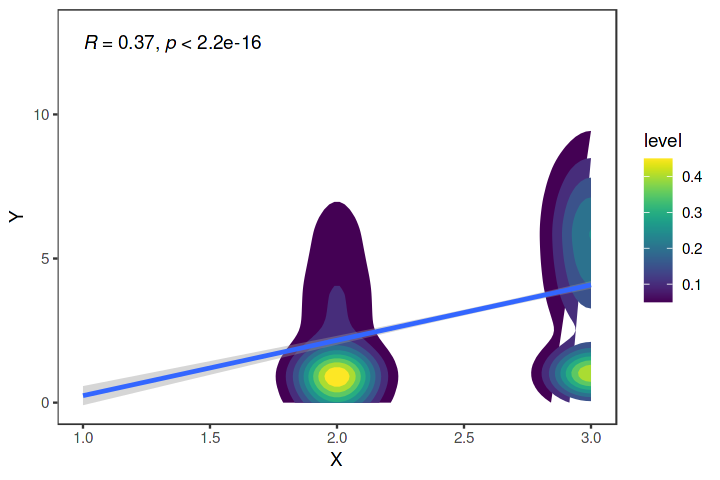

In [556]:
options(repr.plot.width = 6, repr.plot.height = 4)
plot.data <- cbind.data.frame(X = as.integer(sp.obj$cytospace), Y = as.integer(dapi.cnt[, 1])) #%>% { log2(.) }
#ggplot(plot.data, aes(x = X, y = Y)) + geom_pointdensity() + geom_smooth(method = 'lm') + theme_bw() + theme(panel.grid = element_blank()) + stat_cor(method = "pearson") + viridis::scale_color_viridis() + xlab('Predicted by Cell2Spatial') + ylab('Counted using VistoSeg tool')
ggplot(plot.data, aes(x = X, y = Y)) + stat_density2d(geom = 'polygon', aes(fill = stat(level))) + geom_smooth(method = 'lm') + theme_bw() + theme(panel.grid = element_blank()) + stat_cor(method = "spearman") + viridis::scale_fill_viridis()
ggsave(file.path(out.figs.dir, 'data.2.cytospace.dapi.pdf'), width = 6, height = 4)

In [557]:
cor(sp.obj$cytospace, sp.obj$DAPI, method = 'spearman')

[1] 0.3739012

In [507]:
res <- parallel::mclapply(seq(100, 10000, 200), function(idx) {
    our.cnt <- estCellPerSpots(sp.obj, quantile.cut = 0.95, num.genes = idx)
    our.cnt = our.cnt[rownames(dapi.cnt)]
    return(c(Cor = cor(our.cnt, dapi.cnt[, 1] + 1, method = 'spearman'), Idx = idx))
}, mc.cores = 1) %>% do.call(rbind, .)

In [508]:
head(res)

Cor,Idx
0.6025937,100
0.6255181,300
0.6392962,500
0.6391847,700
0.6421147,900
0.6415562,1100


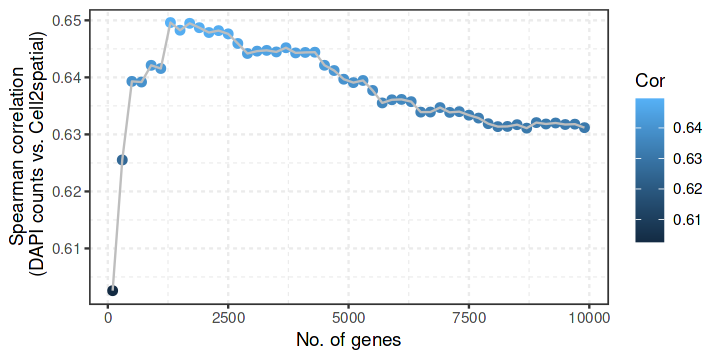

In [510]:
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(res, aes(x = Idx, y = Cor)) + geom_point(aes(color = Cor), size = 2) + geom_line(color = 'grey') + theme_bw() + theme(panel.grid = element_line(linetype = 'dashed')) + xlab('No. of genes') + ylab('Spearman correlation\n (DAPI counts vs. Cell2spatial)')

ggsave(file.path(out.figs.dir, 'data2.dapi.vs.genes.count.pdf'), width = 6, height = 3)
openxlsx::write.xlsx(res, file = file.path(out.data.dir, 'data.vs.genes.count.xlsx'))

In [532]:
res.entire <- rbind.data.frame(
    cbind.data.frame(res.1, SRC ='DATA.1'),
    cbind.data.frame(res, SRC ='DATA.2')
)
head(res.entire)

,Cor,Idx,SRC
,<dbl>,<dbl>,<chr>
1,0.6224446,100,DATA.1
2,0.6098385,300,DATA.1
3,0.6071544,500,DATA.1
4,0.6068313,700,DATA.1
5,0.6051312,900,DATA.1
6,0.6035315,1100,DATA.1


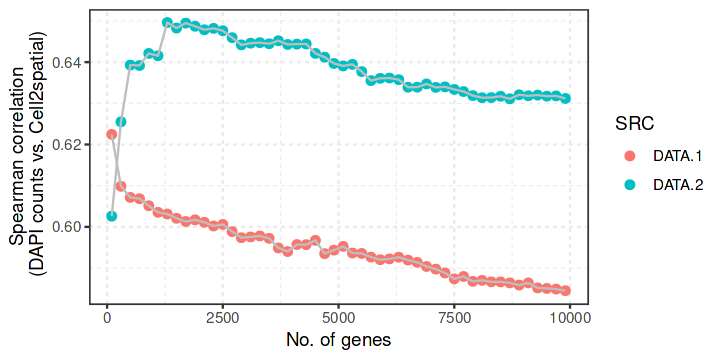

In [538]:
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(res.entire, aes(x = Idx, y = Cor, color = SRC, group = SRC)) + geom_point(size = 2) + geom_line(color = 'grey') + theme_bw() + theme(panel.grid = element_line(linetype = 'dashed')) + xlab('No. of genes') + ylab('Spearman correlation\n (DAPI counts vs. Cell2spatial)')

ggsave(file.path(out.figs.dir, 'merged.dapi.vs.genes.count.pdf'), width = 6, height = 3)
#openxlsx::write.xlsx(res, file = file.path(out.data.dir, 'data2.dapi.vs.genes.count.pdf'))

In [540]:
mean(res.1[, 1])
sd(res.1[, 1])

[1] 0.5948724

[1] 0.007744532

In [541]:
mean(res[, 1])
sd(res[, 1])

[1] 0.6379938

[1] 0.008145954

In [430]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

time zone: Asia/Chongqing
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggpointdensity_0.1.0 viridisLite_0.4.2    ggpubr_0.6.0        
[4] stringr_1.5.1        reticulate_1.38.0    dplyr_1.1.4         
[7] ggplot2_3.5.1        SeuratObject_4.1.3   Seurat_4.3.0        

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.